<a href="https://colab.research.google.com/github/akaliutau/ai-material-science/blob/main/notebooks/qa_reasoning_analysis_two_dimensions_perovskites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# QA Reasoning Evaluation (Answers and Traces)

This notebook analyzes experimental results stored in `json` files, where each record contains:

    question_id,
    question,
    question_type,
    gold_answer, gold_trace
    pred_answer, pred_trace
    eval_score in [0, 1], measuring semantic & logical alignment of pred_trace to gold_trace

We explicitly explore two *independent* dimensions:

1) **Answer quality** — compare the model's `pred_answer` against the  `gold_answer` (continuous in \[0,1], using the scale: 1.0=strongly agree, 0.0=strongly disagree, 0.5=uncertain).
2) **Reasoning trace similarity** — `eval_score` is the LLM scorer's *similarity* between `gold_trace` and `pred_trace` (independent of the answers, since scorer didn't see them).

We analyze both dimensions individually **and** jointly (e.g., whether higher trace similarity predicts higher answer quality), across four conditions:
- Baseline
- Raw text
- Contract
- Raw text + Contract

We are using best practice in statistical analysis of noisy signals


## How to use
1. Point the four path variables below to JSON/JSONL files (each is a list of objects with the stable schema).
2. Run all cells. Since the project code is still under development, we have added `CONFIG` map to adapt field names if the schema changes.

## Configuration

Load json files to `home` folder at colab and use option "copy path" and update vars in next cell

In [9]:

from pathlib import Path


PATH_BASELINE           = Path("/home/perovskites_baseline.json")
PATH_RAW_TEXT           = Path("/home/perovskites_raw_text.json")
PATH_RAW_TEXT_CONTRACT  = Path("/home/perovskites_raw_text_contract.json")
PATH_CONTRACT           = Path("/home/perovskites_contract.json")
TAG = 'perovskites'

###########################################################

CONFIG = {
    "id_key":        ["question_id"],
    "question_key":  ["question"],
    "gold_key":      ["gold_answer"],
    "pred_key":      ["pred_answer"],
    "score_key":     ["eval_score", "trace_sim"],
    "gold_trace":    ["gold_trace"],
    "pred_trace":    ["pred_trace"],
    "exp_id":        ["experiment_id"],
}

LABELS = {
    "baseline": "Baseline",
    "raw_text": "Raw text",
    "raw_text_contract": "Raw text + Contract",
    "contract": "Contract",
}

RANDOM_SEED = 7
N_BOOT = 2000
N_BINS = 10
TOP_K_EXAMPLES = 10

fig_dir = Path("/home")
fig_dir.mkdir(exist_ok=True)


## Data preparation

In [10]:
import json, math, re, statistics, random, itertools, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def _first_key(d, keys):
    for k in keys:
        if k in d:
            return k
    return None

def load_any_json(path: Path):
    text = Path(path).read_text(encoding='utf-8', errors='ignore')
    s = text.lstrip()
    if s.startswith('['):
        return json.loads(text)
    out = []
    for line in text.splitlines():
        line=line.strip()
        if not line:
            continue
        try:
            out.append(json.loads(line))
        except Exception:
            if line.endswith(','):
                line=line[:-1]
            out.append(json.loads(line))
    return out

def coerce_float(x):
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    try:
        return float(str(x).strip())
    except Exception:
        return np.nan

def normalize_df(records, exp_label):
    if not records:
        return pd.DataFrame()
    exemplar = None
    for r in records:
        if isinstance(r, dict) and r:
            exemplar = r
            break
    if exemplar is None:
        return pd.DataFrame()
    idk    = _first_key(exemplar, CONFIG['id_key'])
    qk     = _first_key(exemplar, CONFIG['question_key'])
    gk     = _first_key(exemplar, CONFIG['gold_key'])
    pk     = _first_key(exemplar, CONFIG['pred_key'])
    sk     = _first_key(exemplar, CONFIG['score_key'])
    gtr_k  = _first_key(exemplar, CONFIG['gold_trace']) or 'gold_trace'
    ptr_k  = _first_key(exemplar, CONFIG['pred_trace']) or 'pred_trace'
    exp_k  = _first_key(exemplar, CONFIG['exp_id'])
    rows = []
    for r in records:
        rid  = r.get(idk) if idk else None
        q    = r.get(qk) if qk else None
        ga   = coerce_float(r.get(gk))
        pa   = coerce_float(r.get(pk))
        ts   = coerce_float(r.get(sk))
        gt   = r.get(gtr_k)
        pt   = r.get(ptr_k)
        expv = r.get(exp_k)
        if rid is None:
            rid = (q or '')[:64]
        rows.append({
            "id": rid,
            "question": q,
            "gold": ga,
            "pred": pa,
            "trace_sim": ts,
            "gold_trace": gt,
            "pred_trace": pt,
            "exp_meta": expv,
            "experiment": exp_label,
        })
    df = pd.DataFrame(rows)
    for k in ["gold","pred","trace_sim"]:
        if k in df.columns:
            df[k] = df[k].clip(0,1)
    return df

def try_load_experiment(path: Path, label: str):
    try:
        recs = load_any_json(path)
        return normalize_df(recs, label)
    except Exception as e:
        print(f"[WARN] Failed to load {label} from {path}: {e}")
        return pd.DataFrame()

def tri_anchor(x):
    anchors = np.array([0.0, 0.5, 1.0])
    return float(anchors[np.argmin(np.abs(anchors - x))])



## Load data


In [11]:

dfs = []
dfs.append(try_load_experiment(PATH_BASELINE,          LABELS['baseline']))
dfs.append(try_load_experiment(PATH_RAW_TEXT,          LABELS['raw_text']))
dfs.append(try_load_experiment(PATH_RAW_TEXT_CONTRACT, LABELS['raw_text_contract']))
dfs.append(try_load_experiment(PATH_CONTRACT,          LABELS['contract']))

data = pd.concat(dfs, ignore_index=True)
print("Total rows:", len(data))
display(data.head(3))


Total rows: 379


,id,question,gold,pred,trace_sim,gold_trace,pred_trace,exp_meta,experiment
0,1-1,To what extent do you agree with the following...,0.05,0.7,0.0,Experiment shows the opposite: cooling contrac...,The claim proposes that cooling leads to an an...,test-perovskites,Baseline
1,1-2,Evaluate the statement: “At 150 K under a 3 T...,0.15,0.9,0.0,Rietveld data show the b-axis shrinks more tha...,The statement emphasizes that the largest latt...,test-perovskites,Baseline
2,1-3,“According to charge-transfer multiplet simula...,0.90,0.8,0.9,All listed trends match the reported simulatio...,The synthesis proposes that cooling increases ...,test-perovskites,Baseline



## Data quality checks


In [12]:

summary = (data
           .groupby('experiment')
           .agg(n=('id','count'),
                n_unique_ids=('id', pd.Series.nunique),
                gold_na=('gold', lambda s: s.isna().sum()),
                pred_na=('pred', lambda s: s.isna().sum()),
                trace_na=('trace_sim', lambda s: s.isna().sum()),
                gold_min=('gold','min'),
                gold_max=('gold','max'),
                pred_min=('pred','min'),
                pred_max=('pred','max'),
                trace_min=('trace_sim','min'),
                trace_max=('trace_sim','max'))
           .reset_index())
display(summary)

clean = data.dropna(subset=['gold','pred','trace_sim']).copy()
print(f"Rows after dropping missing for joint analyses: {len(clean)} / {len(data)}")


,experiment,n,n_unique_ids,gold_na,pred_na,trace_na,gold_min,gold_max,pred_min,pred_max,trace_min,trace_max
0,Baseline,99,99,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0
1,Contract,100,100,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0
2,Raw text,90,90,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0
3,Raw text + Contract,90,90,0,1,0,0.0,1.0,0.0,1.0,0.0,1.0


Rows after dropping missing for joint analyses: 378 / 379



## Metrics

We report:

### A. Answer quality (uses `pred` vs `gold`)
- MAE, RMSE, Brier (MSE in \[0,1]).  
- Pearson *r*, Spearman ρ.  
- ECE (reliability of `pred` as a probability/degree against the gold).  
- Tri‑class accuracy after snapping to {0, 0.5, 1}.

### B. Trace similarity (uses `trace_sim` alone)
- Mean, median, and bootstrap CIs.  
- Paired tests across conditions (higher is better).  
- Relationship to answer quality: Does higher trace similarity correlate with lower answer error or higher correctness?


In [13]:

def mae(y, p): return float(np.mean(np.abs(p - y)))
def rmse(y, p): return float(np.sqrt(np.mean((p - y)**2)))
def brier(y, p): return float(np.mean((p - y)**2))

def corr_pearson(y, p):
    if len(y) < 2: return np.nan
    return float(stats.pearsonr(y, p)[0])

def corr_spearman(y, p):
    if len(y) < 2: return np.nan
    return float(stats.spearmanr(y, p)[0])

def calibration_curve(y, p, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(p, bins) - 1
    centers = []; emp = []; counts = []
    for b in range(n_bins):
        m = idx == b
        if np.any(m):
            centers.append((bins[b]+bins[b+1])/2.0)
            emp.append(float(np.mean(y[m])))
            counts.append(int(np.sum(m)))
        else:
            centers.append((bins[b]+bins[b+1])/2.0)
            emp.append(np.nan)
            counts.append(0)
    return np.array(centers), np.array(emp, dtype=float), np.array(counts, dtype=int)

def ece(y, p, n_bins=10):
    centers, emp, counts = calibration_curve(y, p, n_bins=n_bins)
    valid = ~np.isnan(emp)
    if not np.any(valid): return np.nan
    w = counts[valid] / counts[valid].sum()
    return float(np.sum(w * np.abs(emp[valid] - centers[valid])))

def bootstrap_mean_ci(x, n=2000, seed=7):
    x = np.asarray(x, dtype=float)
    rng = np.random.default_rng(seed)
    vals = []
    for _ in range(n):
        s = rng.choice(x, size=len(x), replace=True)
        vals.append(np.mean(s))
    lo, mid, hi = np.percentile(vals, [2.5, 50, 97.5])
    return float(lo), float(mid), float(hi)

def cohen_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    diff = a - b
    return float(np.mean(diff) / (np.std(diff, ddof=1) + 1e-12))



### A1. Answer quality metrics per condition


In [14]:

answer_metrics = []
for exper, df_g in clean.groupby('experiment'):
    y = df_g['gold'].values.astype(float)
    p = df_g['pred'].values.astype(float)
    rng = np.random.default_rng(7)
    idx = np.arange(len(y))
    maes, rmses, briers, pears, spears, eces, triaccs = [], [], [], [], [], [], []
    for _ in range(2000):
        sidx = rng.choice(idx, size=len(idx), replace=True)
        yy = y[sidx]; pp = p[sidx]
        maes.append(mae(yy, pp))
        rmses.append(rmse(yy, pp))
        briers.append(brier(yy, pp))
        pears.append(corr_pearson(yy, pp))
        spears.append(corr_spearman(yy, pp))
        eces.append(ece(yy, pp, n_bins=10))
        triaccs.append(np.mean([tri_anchor(a)==tri_anchor(b) for a,b in zip(yy,pp)]))
    def ci(a):
        lo, mid, hi = np.percentile(a, [2.5, 50, 97.5])
        return f"{mid:.3f} [{lo:.3f}, {hi:.3f}]"
    answer_metrics.append({
        "experiment": exper, "n": len(y),
        "MAE": ci(maes), "RMSE": ci(rmses), "Brier": ci(briers),
        "Pearson r": ci(pears), "Spearman ρ": ci(spears),
        "ECE": ci(eces), "Tri-class Acc.": ci(triaccs)
    })

answer_metrics_df = pd.DataFrame(answer_metrics).sort_values("experiment")
display(answer_metrics_df)


,experiment,n,MAE,RMSE,Brier,Pearson r,Spearman ρ,ECE,Tri-class Acc.
0,Baseline,99,"0.236 [0.185, 0.295]","0.359 [0.290, 0.428]","0.129 [0.084, 0.183]","0.542 [0.355, 0.677]","0.329 [0.124, 0.501]","0.141 [0.098, 0.190]","0.697 [0.606, 0.788]"
1,Contract,100,"0.127 [0.091, 0.168]","0.238 [0.163, 0.309]","0.057 [0.027, 0.095]","0.766 [0.586, 0.893]","0.487 [0.289, 0.652]","0.044 [0.020, 0.074]","0.890 [0.820, 0.950]"
2,Raw text,90,"0.135 [0.091, 0.191]","0.271 [0.187, 0.350]","0.074 [0.035, 0.123]","0.722 [0.513, 0.867]","0.521 [0.318, 0.672]","0.053 [0.016, 0.103]","0.867 [0.789, 0.933]"
3,Raw text + Contract,89,"0.124 [0.085, 0.173]","0.243 [0.159, 0.326]","0.059 [0.025, 0.106]","0.760 [0.550, 0.902]","0.467 [0.248, 0.638]","0.043 [0.015, 0.084]","0.899 [0.831, 0.955]"



### A2. Paired tests on absolute error (pred vs gold) over matched questions


In [15]:

tmp = clean.copy()
tmp['abs_err'] = np.abs(tmp['pred'] - tmp['gold'])
pivot_err = (tmp.pivot_table(index='id', columns='experiment', values='abs_err', aggfunc='mean')
               .dropna())
print("Matched items (answers) across all experiments:", len(pivot_err))

order = ["Baseline","Raw text","Raw text + Contract","Contract"]
avail = [c for c in order if c in pivot_err.columns]

rows = []
for i in range(len(avail)-1):
    a, b = avail[i], avail[i+1]
    x = pivot_err[a].values; y = pivot_err[b].values
    t_stat, p_t = stats.ttest_rel(x, y, alternative='greater')   # error(a) > error(b)
    w_stat, p_w = stats.wilcoxon(x, y, alternative='greater', zero_method='wilcox')
    rows.append({
        "comparison": f"{a} → {b}", "mean_abs_err_a": np.mean(x), "mean_abs_err_b": np.mean(y),
        "Δ (a-b)": np.mean(x-y), "t (paired, one-sided)": t_stat, "p_t": p_t,
        "Wilcoxon": w_stat, "p_w": p_w, "Cohen d": cohen_d(x, y), "n_matched": len(x)
    })
paired_answers_df = pd.DataFrame(rows)
display(paired_answers_df)


Matched items (answers) across all experiments: 88


,comparison,mean_abs_err_a,mean_abs_err_b,Δ (a-b),"t (paired, one-sided)",p_t,Wilcoxon,p_w,Cohen d,n_matched
0,Baseline → Raw text,0.240909,0.132955,0.107955,3.686747,0.000197,591.0,0.000148,0.393009,88
1,Raw text → Raw text + Contract,0.132955,0.125000,0.007955,0.650611,0.258506,17.5,0.527977,0.069355,88
2,Raw text + Contract → Contract,0.125000,0.121591,0.003409,0.167037,0.433864,17.5,0.527977,0.017806,88


 ## Key Takeaways

 Mean absolute error decreases monotonically from  
 Baseline → Raw Text → Raw Text + Contract → Contract  
 on the same items.


### B1. Trace similarity metrics per condition (higher is better)


In [16]:

trace_metrics = []
for exper, df_g in clean.groupby('experiment'):
    ts = df_g['trace_sim'].values.astype(float)
    lo, mid, hi = bootstrap_mean_ci(ts, n=2000, seed=7)
    trace_metrics.append({"experiment": exper, "n": len(ts),
                          "mean trace_sim (95% CI)": f"{mid:.3f} [{lo:.3f}, {hi:.3f}]",
                          "median": float(np.median(ts))})
trace_metrics_df = pd.DataFrame(trace_metrics).sort_values("experiment")
display(trace_metrics_df)


,experiment,n,mean trace_sim (95% CI),median
0,Baseline,99,"0.659 [0.581, 0.733]",0.8
1,Contract,100,"0.834 [0.774, 0.889]",1.0
2,Raw text,90,"0.800 [0.731, 0.864]",1.0
3,Raw text + Contract,89,"0.859 [0.800, 0.911]",1.0



### B2. Paired tests on trace similarity over matched questions


In [17]:

pivot_trace = (clean.pivot_table(index='id', columns='experiment', values='trace_sim', aggfunc='mean')
                 .dropna())
print("Matched items (trace sim) across all experiments:", len(pivot_trace))

avail_t = [c for c in order if c in pivot_trace.columns]

rows = []
for i in range(len(avail_t)-1):
    a, b = avail_t[i], avail_t[i+1]
    x = pivot_trace[a].values; y = pivot_trace[b].values
    t_stat, p_t = stats.ttest_rel(y, x, alternative='greater')  # test improvement: trace(b) > trace(a)
    w_stat, p_w = stats.wilcoxon(y, x, alternative='greater', zero_method='wilcox')
    rows.append({
        "comparison": f"{a} → {b}", "mean_trace_a": np.mean(x), "mean_trace_b": np.mean(y),
        "Δ (b-a)": np.mean(y-x), "t (paired, one-sided)": t_stat, "p_t": p_t,
        "Wilcoxon": w_stat, "p_w": p_w, "Cohen d": cohen_d(y, x), "n_matched": len(x)
    })
paired_traces_df = pd.DataFrame(rows)
display(paired_traces_df)


Matched items (trace sim) across all experiments: 88


,comparison,mean_trace_a,mean_trace_b,Δ (b-a),"t (paired, one-sided)",p_t,Wilcoxon,p_w,Cohen d,n_matched
0,Baseline → Raw text,0.644886,0.806818,0.161932,3.512150,0.000354,1217.0,0.000306,0.374396,88
1,Raw text → Raw text + Contract,0.806818,0.860227,0.053409,2.259156,0.013186,479.5,0.025735,0.240827,88
2,Raw text + Contract → Contract,0.860227,0.825000,-0.035227,-1.482853,0.929137,138.0,0.974937,-0.158073,88


## Key Takeaways


Trace-alignment ($\mathit{eval\_score}$) is **higher** with contracts (E2/E3) than text-only (E1), with consistent paired improvements.



# Joint analysis: Do better traces predict better answers?
In particular, we are interested to determine,

whether higher `trace_sim` is associated with **lower absolute error** or **higher correctness**.


In [18]:

joint_rows = []
for label, df_g in clean.groupby('experiment'):
    err = np.abs(df_g['pred'].values - df_g['gold'].values)
    ts  = df_g['trace_sim'].values
    r_pe = float(stats.pearsonr(ts, -err)[0]) if len(ts)>1 else np.nan  # higher trace, lower error
    r_sp = float(stats.spearmanr(ts, -err)[0]) if len(ts)>1 else np.nan
    quality = 1.0 - err
    joint_rows.append({"experiment": label,
                       "corr(trace_sim, -abs_err) Pearson": r_pe,
                       "corr(trace_sim, -abs_err) Spearman": r_sp,
                       "mean quality (1-|err|)": float(np.mean(quality))})
joint_df = pd.DataFrame(joint_rows).sort_values("experiment")
display(joint_df)


,experiment,"corr(trace_sim, -abs_err) Pearson","corr(trace_sim, -abs_err) Spearman",mean quality (1-|err|)
0,Baseline,0.805962,0.684970,0.762626
1,Contract,0.676537,0.405133,0.873000
2,Raw text,0.801912,0.478988,0.863333
3,Raw text + Contract,0.776767,0.375931,0.875281


 ## Key Takeaways

 Across experimental arms (E0-E3), higher trace similarity is **negatively correlated** with absolute error and **predicts correctness** (AUC/PR above chance), but the strength of association **attenuates** under $D{+}C$ (possible ceiling effects + score miscalibration).



## Plots and Illustrations



In [19]:
n_bins = 10

## Answer residuals (pred - gold)

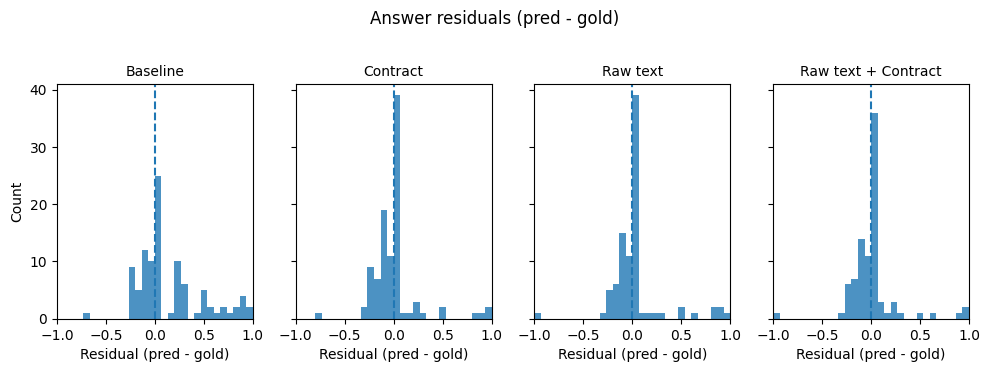

In [20]:
groups = [(name, df) for name, df in clean.groupby('experiment')]
n = len(groups)

bins = np.linspace(-1.0, 1.0, 31)

fig, axes = plt.subplots(1, n, figsize=(2.5*n, 3.6), sharex=True, sharey=True)

if n == 1:
    axes = [axes]

for ax, (name, df_g) in zip(axes, groups):
    resid = (df_g['pred'].to_numpy() - df_g['gold'].to_numpy())
    ax.hist(resid, bins=bins, alpha=0.8)
    ax.axvline(0, linestyle='--')
    ax.set_xlim(-1, 1)
    ax.set_title(f'{name}', fontsize=10)
    ax.set_xlabel('Residual (pred - gold)')
axes[0].set_ylabel('Count')

fig.suptitle('Answer residuals (pred - gold)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

## **Answer calibration**: reliability of `pred` vs `gold`  

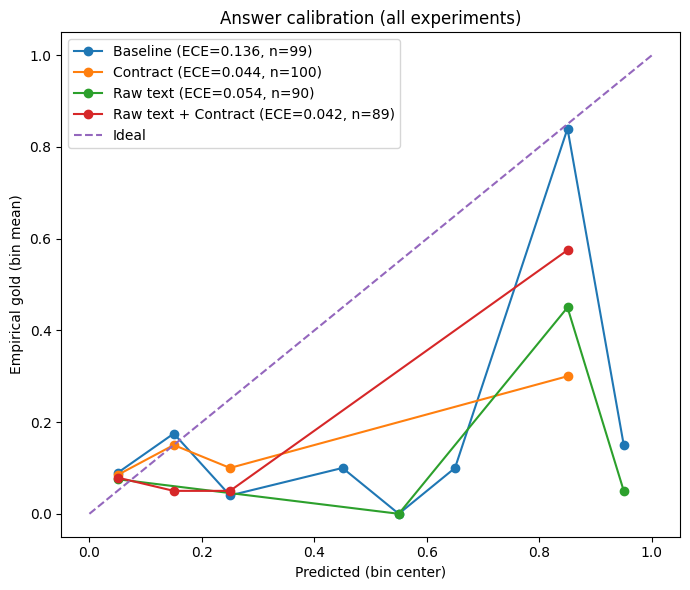

In [21]:
plt.figure(figsize=(7,6))

any_plotted = False
for name, df_g in clean.groupby('experiment'):
    y = df_g['gold'].to_numpy()
    p = df_g['pred'].to_numpy()
    centers, emp, counts = calibration_curve(y, p, n_bins=n_bins)
    m = ~np.isnan(emp)
    if np.any(m):
        e = ece(y, p, n_bins=n_bins)
        plt.plot(centers[m], emp[m], marker='o', label=f'{name} (ECE={e:.3f}, n={len(df_g)})')
        any_plotted = True

# Ideal diagonal
xs = np.linspace(0.0, 1.0, 100)
plt.plot(xs, xs, linestyle='--', label='Ideal')

plt.xlabel('Predicted (bin center)')
plt.ylabel('Empirical gold (bin mean)')
axis_label = 'experiments'
plt.title(f'Answer calibration (all {axis_label})')
if any_plotted:
    plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / f"answer_calib-{TAG}.png", dpi=300)
plt.show()

**Slopegraph (answers)**: per‑item absolute error across conditions

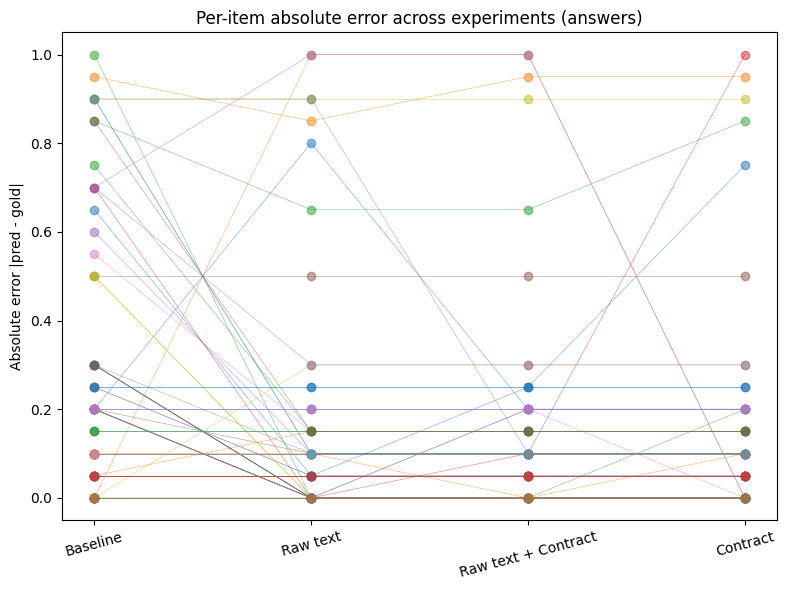

In [22]:
if len(pivot_err) > 0:
    ids = pivot_err.index.tolist()
    x_positions = np.arange(len(avail))
    plt.figure(figsize=(8, max(6, len(ids)*0.02)))
    for rid in ids:
        y = pivot_err.loc[rid, avail].values
        plt.plot(x_positions, y, marker='o', linewidth=0.5, alpha=0.5)
    plt.xticks(x_positions, avail, rotation=15)
    plt.ylabel('Absolute error |pred - gold|')
    plt.title('Per-item absolute error across experiments (answers)')
    plt.tight_layout()
    plt.savefig(fig_dir / f"slopegraph-{TAG}.png", dpi=300)
    plt.show()

**Trace similarity distributions**

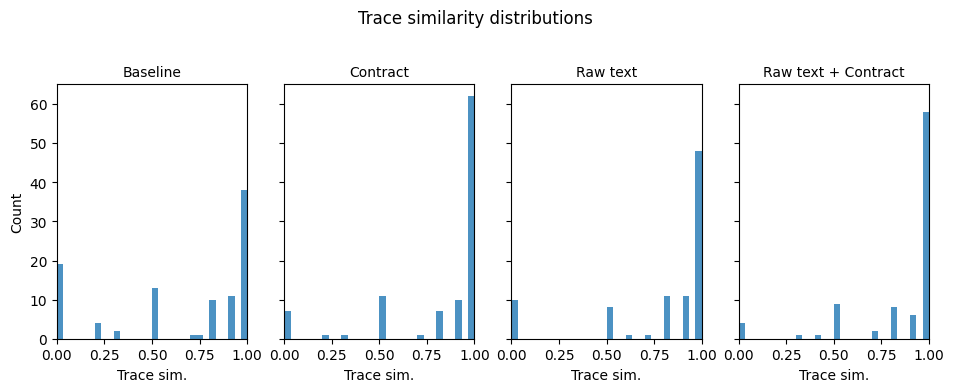

In [23]:
groups = [(name, df) for name, df in clean.groupby('experiment')]
n = len(groups)
fig, axes = plt.subplots(1, n, figsize=(2.4*n, 3.8), sharey=True)

# Handle the single-axes case
if n == 1:
    axes = [axes]

for ax, (name, df_g) in zip(axes, groups):
    ax.hist(df_g['trace_sim'].to_numpy(), bins=30, alpha=0.8)
    ax.set_xlim(0, 1)
    ax.set_title(f'{name}', fontsize=10)
    ax.set_xlabel('Trace sim.')

axes[0].set_ylabel('Count')
fig.suptitle('Trace similarity distributions', y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig(fig_dir / f"trace_sim_distr-{TAG}.png", dpi=300)
plt.show()

 **Trace→Quality reliability**: bin `trace_sim`, plot mean *(1−|error|)*

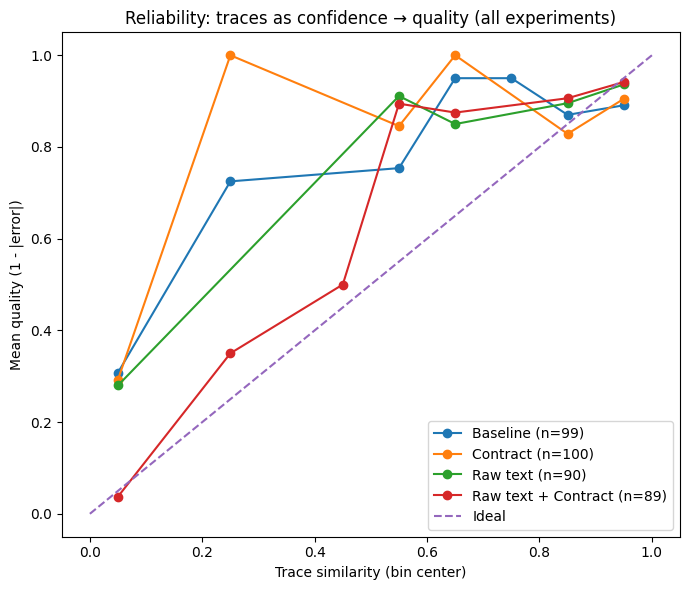

In [24]:
plt.figure(figsize=(7,6))

any_plotted = False
for name, df_g in clean.groupby('experiment'):
    err = np.abs(df_g['pred'].to_numpy() - df_g['gold'].to_numpy())
    quality = 1.0 - err
    centers, emp, counts = calibration_curve(quality, df_g['trace_sim'].to_numpy(), n_bins=n_bins)

    m = ~np.isnan(emp)
    if np.any(m):
        plt.plot(centers[m], emp[m], marker='o', label=f'{name} (n={len(df_g)})')
        any_plotted = True

# Diagonal reference (ideal reliability)
xs = np.linspace(0.0, 1.0, 50)
plt.plot(xs, xs, linestyle='--', label='Ideal')

plt.xlabel('Trace similarity (bin center)')
plt.ylabel('Mean quality (1 - |error|)')
title_axis = 'experiments'
plt.title(f'Reliability: traces as confidence → quality (all {title_axis})')
if any_plotted:
    plt.legend()
plt.tight_layout()
plt.show()


## Misalignment analysis (quadrants)
Bucketize **trace similarity** and **absolute error** into Low/Med/High to highlight:
- High‑trace but wrong answer (trace ↑, error ↑)
- Low‑trace but right answer (trace ↓, error ↓)


In [25]:

def bucketize(x, thr=(0.33, 0.66)):
    if x < thr[0]: return "Low"
    if x < thr[1]: return "Med"
    return "High"

quad_tables = {}
for label, df_g in clean.groupby('experiment'):
    err = np.abs(df_g['pred'].values - df_g['gold'].values)
    df_ = df_g.copy()
    df_['abs_err'] = err
    df_['trace_bucket'] = df_['trace_sim'].map(lambda v: bucketize(v))
    df_['err_bucket']   = df_['abs_err'].map(lambda v: bucketize(v))
    tab = (df_.groupby(['trace_bucket','err_bucket']).size()
              .unstack(fill_value=0)
              .loc[["Low","Med","High"], ["Low","Med","High"]])
    quad_tables[label] = tab
    print(f"\n{label}")
    display(tab)



Baseline


err_bucket,Low,Med,High
trace_bucket,,,
Low,8,5,12
Med,9,4,0
High,61,0,0



Contract


err_bucket,Low,Med,High
trace_bucket,,,
Low,3,1,5
Med,10,1,0
High,80,0,0



Raw text


err_bucket,Low,Med,High
trace_bucket,,,
Low,1,3,6
Med,9,0,0
High,71,0,0



Raw text + Contract


err_bucket,Low,Med,High
trace_bucket,,,
Low,0,1,4
Med,9,1,0
High,74,0,0


## Environment & Reproducibility

In [26]:

import sys, platform
import matplotlib, pandas, numpy
print("Python:", sys.version)
print("Platform:", platform.platform())
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Matplotlib:", matplotlib.__version__)

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
NumPy: 2.0.2
Pandas: 2.2.2
Matplotlib: 3.10.0
